<a href="https://colab.research.google.com/github/jpafcampos/VAE_dogs/blob/main/vae_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import torch
from torch import nn
import os, random
import collections
import torch
import torchvision
import numpy as np
from torch.utils import data
import torchvision
import torchvision.transforms as T
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from skimage.io import imread
from skimage.transform import resize, rescale
import skimage.transform as scikit_transform
import scipy
import skimage as ski

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image

from torch.optim import lr_scheduler


In [5]:
%cd /content/drive/MyDrive/dog_breeds

[Errno 2] No such file or directory: '/content/drive/MyDrive/dog_breeds'
/content


In [7]:
class DogsDataset(data.Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [14]:

#Read the dataset 
PATH = '/content/drive/MyDrive/dog_breeds/'
labels = pd.read_csv(PATH+'labels.csv')
labelnames = pd.read_csv(PATH + 'sample_submission.csv').keys()[1:]
print("Train folder has ", len(os.listdir(PATH+'train')),'images which matches with label\'s', len(labels),'images')

Train folder has  10222 images which matches with label's 10222 images


In [15]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.85)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(8689, 121) (1533, 121)


In [140]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, PATH+'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, PATH+'train/', transform=ds_trans)

train_dl = data.DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = data.DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [141]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([4, 3, 256, 256]) torch.Size([4])


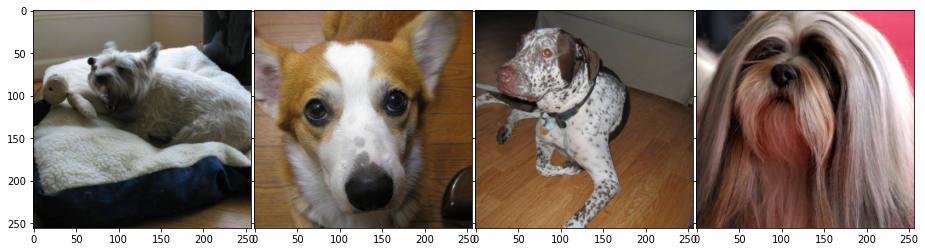

In [142]:
img, label = next(iter(train_dl))
#print(label)
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [117]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [216]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims, block= BasicBlock):
        super(VariationalEncoder, self).__init__()

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, 2)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, 512)
        self.fc1 = nn.Linear(512 , latent_dims)
        self.fc2 = nn.Linear(512 , latent_dims)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.relu(x)

        w_mean = self.fc1(x)
        w_std  = self.fc2(x)
        return w_mean, w_std

In [233]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(latent_dims, 500)
        self.fc2 = nn.Linear(500, 14*14*32)
        self.deconv1 = nn.ConvTranspose2d(32,64, kernel_size=3, stride =2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32, kernel_size=3, stride =2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32,16, kernel_size=3, stride =2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(16,3, kernel_size=3, stride =2, padding=1, output_padding=1)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, z):
        print(z.shape)
        x = self.fc1(z)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)

        x = x.view(-1,32,14,14)
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.relu(x)
        x = self.deconv3(x)
        x = self.relu(x)
        x = self.deconv4(x)
        x = self.sigmoid(x)
        return x

In [234]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, is_cuda = True):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        self.is_cuda = is_cuda

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if self.is_cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()

        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        print(z.shape)
        res = self.decoder(z)
        return res, mu, logvar

In [235]:
enc = VariationalEncoder(300)
enc = enc.to(device)

In [236]:
img = torch.rand([1,3,224,224])

In [237]:
img = img.to(device)

In [238]:
mu, std = enc(img)


In [239]:
VAE = VariationalAutoencoder(300)
VAE = VAE.to(device)

In [240]:
out, _,_ = VAE(img)
out.shape

torch.Size([1, 300])
torch.Size([1, 300])


torch.Size([1, 3, 224, 224])